## Data Summary

In [17]:
import pandas as pd

dataset_path = "/work/JDH_python/datasets/datasets.xlsx"
sheets = ["tatavla", "fener"]
target_col = "Migration"

results = []

for sheet in sheets:
    df = pd.read_excel(dataset_path, sheet_name=sheet)
    df_clean = df.dropna(subset=[target_col])

    results.append({
        "Sheet": sheet.capitalize(),
        "Rows with Movements": len(df_clean)
    })

df_summary = pd.DataFrame(results)

df_summary

,Sheet,Rows with Movements
0,Tatavla,2511
1,Fener,417


## Functions and workflow for stage 1 (Formating and geolocation)

In [3]:
pip install pandas openai openpyxl


Note: you may need to restart the kernel to use updated packages.


In [1]:
#===================
#LIBRARY LOADS
#===================
import os, time, math, random, json
from typing import Any, Dict, List
import pandas as pd
from openai import OpenAI


In [55]:
#===================
#PARAMETERS
#===================
FILE = "/work/JDH_python/datasets/datasets.xlsx"
SHEET = "tatavla"
OUTPUT = "/work/JDH_python/datasets/movements_context_tatavla2.xlsx"
OUTPUT_NO_NA = "/work/JDH_python/datasets/movements_no_na_with_context_tatavla.xlsx"

BATCH_SIZE = 15         # batch size (all these rows go in one call)
SLEEP_MIN = 2.0         # Minimun seconds to wait before making another API call
SLEEP_MAX = 15.0        # Maximun seconds to wait before making another API call
START_ROW = 0           # initial row (0-based)
MAX_ROWS = "None"       # maximum number of rows (None = all)
MODEL = "gpt-4o"        # Model from OPENAI

START_ROW = 0 if START_ROW in ("0", 0, None, "None", "") else int(START_ROW)
if MAX_ROWS in (None, "None", ""):
    MAX_ROWS = None
else:
    MAX_ROWS = int(MAX_ROWS)

# PROMPT MODE SWITCH (choose: "with_context" or "no_context")
PROMPT_MODE = "with_context"

#===================
#API KEY
#===================
OPENAI_API_KEY = "PASTE_OPENAI_KEY_HERE"
if not OPENAI_API_KEY or OPENAI_API_KEY.startswith("sk-WRITE_YOUR_OWN"):
    raise RuntimeError("Place your OpenAI API key in OPENAI_API_KEY.")
client = OpenAI(api_key=OPENAI_API_KEY)

In [56]:

#===================
#PROMPTS
#===================
def build_batch_prompt(batch_rows: List[Dict[str, Any]]) -> str:
    """
    batch_rows: list[dict] with: defter, origin, movement
    """
    header_with_context = (
        "Data context: Data comes from Ottoman population registers of the Greek Orthodox community in Istanbul (early–mid 19th c).\n"
        "Task: For EACH record below, infer, reconstruct, and geolocate the migration movements as a chronological list.\n"
        "Output: Return ONLY valid JSON matching the provided schema (a single object with a 'results' array).\n"
        "\n"
        "STRICT RULES AND COMPLEMENTARY CONTEXT:\n"
        "1. The departure point is always Tatavla.\n"
        "2. Consider ONLY movements explicitly mentioned — do not invent locations or dates.\n"
        "3. 'Amed', 'Amed-Şod', and 'return' mean the person went back to Tatavla.\n"
        "4. 'Memleket' and 'vilayet' mean 'hometown' (the person traveled to their place of origin).\n"
        "5. Latitude and longitude must be numeric values (will be rounded to 2 decimals later).\n"
        "6. Hijri → Gregorian conversion is MANDATORY and must follow these tiered rules:\n"
        "   • If only the year (e.g., '1266') is given → return the Gregorian year (e.g., 'YYYY').\n"
        "   • If the month and year are given (e.g., 'B1266' or 'B.1266') → return the Gregorian month name and year (e.g., 'MM/YYYY').\n"
        "   • If day, month, and year are given (e.g., '27B1266' or '27.B.1266') → return the Gregorian date in full format (MM/DD/YYYY).\n"
        "   • If the Hijri information is missing, incomplete, or ambiguous → set 'date_gregorian' = null.\n"
        "   • Never invent or estimate values. Only convert from the provided Hijri parts.\n"
        "7. If no Hijri date is available, both 'date_hijri' and 'date_gregorian' must be null.\n"
        "8. Think step-by-step INTERNALLY (chain of thought), but do NOT show reasoning — output JSON only.\n"
        "\n"
        "Hijri month abbreviations used in Ottoman/defter practice (accept with or without dots; case-insensitive; handle Turkish letters):\n"
        "The abbreviations below correspond to the 12 months of the Islamic (Hijri lunar) calendar in ottoman turkish.\n"
        "Normalize the abbreviations to the standard classic islamic calendar to convert the date accurately to the gregorian calendar\n"
        "Ottoman abbreviations found in the entries correspond to the Islamic calendar as follows (Format: Abbreviation = Ottoman name = equivalent in the classical Islamic calendar):\n"
        "   M  = Muharrem = al-Muḥarram (month 1)\n"
        "   S  = Safer = Ṣafar (month 2)\n"
        "   Ra = Rabiü'l-evvel = Rabi Al-Awwal (month 3)\n"
        "   R  = Rabiü'l-ahir = rabi Al-Thani (month 4)\n"
        "   Ca = Cemaziye'l-evvel = Jumada Al-Awwal (month 5)\n"
        "   C  = Cemaziye'l-ahir = Jumada Al-Thani (month 6)\n"
        "   B  = Receb = Rajab (month 7)\n"
        "   Ş  = Şaban = Sha'ban (month 8)\n"
        "   N  = Ramazan = Ramadan (month 9)\n"
        "   L  = Şevval = Shawwal (month 10)\n"
        "   Za = Zilkade = Dhul-Qa'dah (month 11)\n"
        "   Z  = Zilhicce = Dhul-Hijjah (month 12)\n"
        "Notes for parsing:\n"
        "   • Historical entries may omit dots entirely (e.g., '27B1266', 'B1266'); treat '27.B.1266' and '27B1266' equivalently.\n"
        "   • Accept spacing variants (e.g., '27 B 1266') and Unicode variants of 'Ş/Ş'.\n"
        "   • Month-only, month+year or year inputs should still produce partial Gregorian outputs (MM or MM/YYYY or YYYY).\n"
        "\n"
        "INTERNAL REASONING STEPS (DO NOT OUTPUT THESE STEPS):\n"
        "   1) Parse each record; identify tokens for places and dates.\n"
        "   2) Normalize textual variants (spacing, dots, Unicode) without altering meaning. for places of origin normalize the name (Asitaneli-> Asitane)\n"
        "   3) Extract dates (MM/DD/YYY) from each entry\n"
        "   4) Convert the extracted date, written in the Ottoman-Turkish abbreviation system of the Islamic (Hijri) lunar calendar, into its corresponding Gregorian date and consider Ottoman abbreviations to the Islamic calendar using the ottoman abreviations given above and according to completeness (YYYY; MM/YYYY; MM/DD/YYYY); if ambiguous, set null.\n"
        "     • Base your reasoning exclusively on the Hijri month abbreviations. For instance ‘N’=Ramadan, so 14 N. 1266'  is equal to  '07/24/1850 in gregorian. use your built-in understanding of approximate historical date correlations between the Hijri and Gregorian calendars.\n"
        "   6) Geolocate each place (name → latitude/longitude) consistently across records.\n"
        "   7) Build the 'movements' array with place, latitude, longitude, date_hijri, date_gregorian.\n"
        "   8) Validate that the final JSON strictly matches the provided schema.\n"
        "\n"
        "Example on date formatting and accurate conversions from islamic to gregorian (MM/YYYY or YYYY means you should calculate the month and year):\n"
        "   '14 N. 1266'  →  '07/24/1850'\n"
        "   '1 B. 1263'  →  '06/15/1847'\n"
        "   '1 B. 1265'  →  '05/23/1849'\n"
        "   '1 Ca. 1270'  →  '01/30/1854'\n"
        "   '1 Za. 1260'  →  '11/12/1844'\n"
        "  '1 Ş. 1263'  →  '07/15/1847'\n"
        "  '1 M. 1272'  →  '09/13/1855'\n"
        "   'B.1266'     →  'MM/YYYY'\n"
        "   '1266'       →  'YYYY'\n"
        "   '(no date)'  →  null\n"
        "\n"
        "Records:\n"
    )

    header_no_context = (
        "Task: For EACH record below, infer, reconstruct, and geolocate the migration movements as a chronological list.\n"
        "STRICT RULES:\n"
        "1. The departure point is always Tatavla.\n"
        "2. Consider ONLY movements explicitly mentioned — do not invent locations or dates.\n"
        "3. Latitude and longitude must be numeric values (will be rounded to 2 decimals later).\n"
        "4. Hijri → Gregorian conversion is MANDATORY and must follow these tiered rules:\n"
        "   • If only the year (e.g., '1266') is given → return the Gregorian year (e.g., '1849').\n"
        "   • If the month and year are given (e.g., 'B.1266') → return the Gregorian month name and year (e.g., 'MM/YYYY').\n"
        "   • If day, month, and year are given (e.g., '27.B.1266') → return the Gregorian date in full format (MM/DD/YYYY).\n"
        "   • If the Hijri information is missing, incomplete, or ambiguous → set 'date_gregorian' = null.\n"
        "   • Never invent or estimate values. Only convert from the provided Hijri parts.\n"
        "5. If no Hijri date is available, both 'date_hijri' and 'date_gregorian' must be null.\n"
        "Output: Return ONLY valid JSON matching the provided schema (a single object with a 'results' array). Do NOT include explanations.\n"
        "Think step-by-step INTERNALLY (chain of thought) and DO NOT reveal your reasoning; output JSON only.\n"
        "\n"
        "INTERNAL REASONING STEPS (DO NOT OUTPUT THESE STEPS):\n"
        "   1) Parse each record; detect candidate locations and dates from the text.\n"
        "   2) Normalize extracted strings and determine which date parts (day/month/year) are present.\n"
        "   3) Infer the chronological order of movements and ensure the sequence starts from the departure point.\n"
        "   4) Geolocate each place (derive latitude/longitude) consistently for identical names.\n"
        "   5) Convert Hijri to Gregorian to the fullest extent allowed by available parts (year; month+year; day+month+year); if not possible, set null.\n"
         "Example on date formatting:\n"
        "   '27.B.1266'  →  'MM/DD/YYY'\n"
        "   'B.1266'     →  'MM/YYYY'\n"
        "   '1266'       →  'YYYY'\n"
        "   '(no date)'  →  null\n"
        "\n"
        "   6) Assemble the 'movements' array per record.\n"
        "   7) Validate that the final JSON strictly matches the provided schema.\n"
        "\n"
        "Records:\n"
    )

    header = header_with_context if PROMPT_MODE == "with_context" else header_no_context

    lines = []
    for r in batch_rows:
        lines.append(
            f"- Defter: {r['defter']}\n"
            f"  Origin: {r['origin']}\n"
            f"  Movements: {r['movement']}\n"
        )
    return header + "\n".join(lines)

In [30]:
#===================
#JSON SCHEMA FOR STRUCTURED OUTPUT
#===================
BATCH_SCHEMA = {
    "name": "batch_migration_paths",
    "schema": {
        "type": "object",
        "properties": {
            "results": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "defter": { "type": ["string", "number"] },
                        "movements": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "place": { "type": "string" },
                                    "latitude": { "type": "number" },
                                    "longitude": { "type": "number" },
                                    "date_hijri": { "type": ["string", "null"] },
                                    "date_gregorian": { "type": ["string", "null"] }
                                },
                                "required": ["place","latitude","longitude","date_hijri","date_gregorian"],
                                "additionalProperties": False
                            }
                        }
                    },
                    "required": ["defter","movements"],
                    "additionalProperties": False
                }
            }
        },
        "required": ["results"],
        "additionalProperties": False
    }
}

In [35]:
#===================
#UTILITIES
#===================
def chunk_indices(n_rows: int, batch_size: int):
    for start in range(0, n_rows, batch_size):
        yield start, min(start + batch_size, n_rows)

def sleep_between_batches(min_s: float, max_s: float):
    if max_s > 0:
        time.sleep(random.uniform(min_s, max_s))

def round2(x):
    try:
        return round(float(x), 2)
    except Exception:
        return x

def call_openai_structured_batch(prompt: str) -> Dict[str, Any]:
    """
    Return an object with 'results': [ {defter, movements:[...]}, ... ]
    (perform One API call for the entire batch)
    """
    resp = client.chat.completions.create(
        model=MODEL,
        temperature=0.0,
        response_format={"type": "json_schema", "json_schema": BATCH_SCHEMA},
        messages=[
            {"role": "system", "content": "You are a precise extractor of historical migration paths. Think step-by-step INTERNALLY and output valid JSON only."},
            {"role": "user", "content": prompt}
        ],
        max_completion_tokens=8000,  # adjust according to batch size
    )
    content = (resp.choices[0].message.content or "").strip()
    return json.loads(content)  # dict with 'results'


In [ ]:
#===================
#MAIN PIPELINE
#===================
def process_excel_batches_prompt_batching():
    # 1) Read spreadsheets and remove rows with missing (NA) values
    print("Current directory:", os.getcwd())
    print("File exists?", os.path.exists(FILE))
    df = pd.read_excel(FILE, sheet_name=SHEET)
    df = df[df["Migration"].notna()].copy()

    if START_ROW > 0:
        df = df.iloc[START_ROW:].copy()
    if MAX_ROWS is not None:
        df = df.iloc[:MAX_ROWS].copy()

    total_rows = len(df)
    if total_rows == 0:
        print("There are no entries to process after filtering.")
        return

    n_batches = math.ceil(total_rows / max(1, int(BATCH_SIZE)))
    print(f"Processing {total_rows} entries in {n_batches} batches of size {BATCH_SIZE} (prompt batching).")

    original_df = pd.read_excel(FILE, sheet_name=SHEET)

    # Cache lat/lon by location
    location_cache: Dict[str, Any] = {}
    flattened_rows: List[Dict[str, Any]] = []

    # 2) Iterate by batches
    for b_idx, (s, e) in enumerate(chunk_indices(total_rows, BATCH_SIZE), start=1):
        batch_df = df.iloc[s:e].copy()
        print(f"\n— Batch {b_idx}/{n_batches} → rows [{s}:{e}) → 1 call to the API")

        # 2.1) Prepare batch records
        batch_payload = []
        for _, row in batch_df.iterrows():
            batch_payload.append({
                "defter": row.get("Defter"),
                "origin": row.get("Place of origin", ""),
                "movement": row["Migration"]
            })

        # 2.2) Build prompt for the ENTIRE batch
        prompt = build_batch_prompt(batch_payload)
        try:
            batch_obj = call_openai_structured_batch(prompt)  # dict with 'results'
            batch_result = batch_obj.get("results", [])       # list of items
        except Exception as ex:
            print(f"   ✗ batch {b_idx} error LLM: {ex}")
            sleep_between_batches(SLEEP_MIN, SLEEP_MAX)
            continue

        # 2.3) Index results by 'defter'
        result_by_defter: Dict[str, List[Dict[str, Any]]] = {}
        for item in batch_result:
            # normalize string to map safely
            result_by_defter[str(item.get("defter"))] = item.get("movements", []) or []

        # 2.4) assign coordinates
        for _, row in batch_df.iterrows():
            defter_key = str(row.get("Defter"))
            moves = result_by_defter.get(defter_key, []) or []

            row_out: Dict[str, Any] = {"Defter": row.get("Defter")}
            for i, m in enumerate(moves, 1):
                place_key = (m.get("place") or "").strip()
                if place_key and place_key in location_cache:
                    lat, lon = location_cache[place_key]
                else:
                    lat = round2(m.get("latitude"))
                    lon = round2(m.get("longitude"))
                    if place_key:
                        location_cache[place_key] = (lat, lon)

                row_out[f"location_{i}"] = place_key
                row_out[f"latitude_{i}"] = lat
                row_out[f"longitude_{i}"] = lon
                row_out[f"date_hijri_{i}"] = m.get("date_hijri")
                row_out[f"date_gregorian_{i}"] = m.get("date_gregorian")

            flattened_rows.append(row_out)

        # 2.5) save batch
        expanded_df = pd.DataFrame(flattened_rows)
        if not expanded_df.empty:
            merged = original_df.merge(expanded_df, on="Defter", how="left")
            merged.to_excel(OUTPUT, index=False)
            print(f"   ✓ partial save → '{OUTPUT}' (processed entries: {len(expanded_df)})")

        # 2.6) Apply time sleep between batches
        sleep_between_batches(SLEEP_MIN, SLEEP_MAX)

    # save version without rows where "Migration into (travel)" is NaN
    final_df = pd.read_excel(OUTPUT)
    clean_df = final_df[final_df["Migration"].notna()].copy()
    clean_df.to_excel(OUTPUT_NO_NA, index=False)
    print(f"   Clean file (no NA in 'Migration') → '{OUTPUT_NO_NA}' (rows: {len(clean_df)})")

    print(f"\n Final save → '{OUTPUT}'")

# Run pipeline
process_excel_batches_prompt_batching() #individual run (take the sheet and prompt mode specified at the beginning)

# ===== loop to run everything at the same time =====
#SHEETS_TO_RUN = ["tatavla", "fener"]         # <— sheets to run from datasets.xlsx
#MODES_TO_RUN  = ["with_context", "no_context"]
#
#for sheet_name in SHEETS_TO_RUN:
#    for mode in MODES_TO_RUN:
#        print(f"\n Running sheet='{sheet_name}' | mode='{mode}'")
#
#        # Override the globals
#        SHEET = sheet_name
#        PROMPT_MODE = mode
#
#        # Change outputs so each run has its own file (no overwrite):
#        base_dir = "/work/JDH_python/datasets"
#        OUTPUT = f"{base_dir}/movements_{mode}_{sheet_name}.xlsx"
#        OUTPUT_NO_NA = f"{base_dir}/movements_no_na_{mode}_{sheet_name}.xlsx"
#
#       # Run your existing pipeline as-is
#        process_excel_batches_prompt_batching()





In [11]:
 !pip install geopy ratelimit tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.3 MB/s eta 0:00:00
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5894 sha256=1b4bde81ebfb73e577594a76f896e8c17073bab66a6428cc9d493526e56a30f9
  Stored in directory: /home/jovyan/.cache/pip/wheels/ee/d5/e5/8fbffe089140fb498987b7709becf861086daace105d243475
Successfully built ratelimit


In [ ]:
# GEOLOCATION WITH GEOPY

#===================
# FILE PATHS
#===================
FILE_INPUT  = "/work/JDH_python/datasets/movements_no_na_no_context_fener.xlsx"  # use the same pipeline output
SHEET_INPUT = "Sheet1"
OUTPUT_GEO  = "/work/JDH_python/datasets/validation_no_context_fener.xlsx"
CACHE_FILE  = "/work/JDH_python/datasets/geopy_cache.json"

#===================
# LIBRARIES
#===================
import os, json, time, re, unicodedata
import pandas as pd
from tqdm import tqdm
from ratelimit import limits, sleep_and_retry
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from geopy.distance import geodesic
import requests  # Aladhan API

#===================
# CONFIGURATION
#===================
LOCATION_PREFIX = "location_"
LLM_LAT_PREFIX  = "latitude_"
LLM_LON_PREFIX  = "longitude_"
HIJRI_PREFIX    = "date_hijri_"
GREG_PREFIX     = "date_gregorian_"

USER_AGENT = "Digital_History_Research (contact: jbote001@odu.edu)"
COUNTRY_CODES = None       # no country bias
ROUND_DECIMALS = 2
REQUESTS_PER_SECOND = 1
MIN_PAUSE_SECONDS  = 1.1
MAX_BACKOFF_SECONDS = 30

# Aladhan rate limit
ALADHAN_RPS = 3

#===================
# PLACE NORMALIZATION
#===================
def normalize_place_name(name):
    """
    Normalize place names to avoid duplicates such as
    'Kalkadelen' vs 'kalkanedelen' → 'Kalkandelen'.
    """
    if not isinstance(name, str):
        if name is None or (isinstance(name, float) and pd.isna(name)):
            return ""
        name = str(name)

    name = name.strip()
    name = re.sub(r"\s+", " ", name)

    name_no_acc = "".join(
        c for c in unicodedata.normalize("NFD", name)
        if unicodedata.category(c) != "Mn"
    )

    key = name_no_acc.lower()

    MANUAL_CANON = {
        "kalkadelen": "Kalkandelen",
        "kalkanedelen": "Kalkandelen",
        # add more variants if needed when using our methodology.
    }

    if key in MANUAL_CANON:
        return MANUAL_CANON[key]

    return name_no_acc.title()

#===================
# LOAD OR INIT CACHE
#===================
def load_cache(path):
    if os.path.exists(path):
        try:
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)
            return {k: tuple(v) if isinstance(v, list) else v for k, v in data.items()}
        except Exception:
            return {}
    return {}

def save_cache(cache, path):
    tmp = {}
    for k, v in cache.items():
        if isinstance(v, tuple):
            tmp[k] = list(v)
        else:
            tmp[k] = v
    with open(path, "w", encoding="utf-8") as f:
        json.dump(tmp, f, ensure_ascii=False, indent=2)

geo_cache = load_cache(CACHE_FILE)
geo_cache = {k: v for k, v in geo_cache.items()
             if not (isinstance(v, tuple) and v == (None, None))}
save_cache(geo_cache, CACHE_FILE)

#===================
# GEOCODER SETUP
#===================
geocoder = Nominatim(user_agent=USER_AGENT)

@sleep_and_retry
@limits(calls=REQUESTS_PER_SECOND, period=1)
def _geocode_once(address):
    if COUNTRY_CODES:
        return geocoder.geocode(address, country_codes=COUNTRY_CODES,
                                addressdetails=False, timeout=10)
    return geocoder.geocode(address, addressdetails=False, timeout=10)

def geocode_with_backoff(address):
    """Geocode address with cache + exponential backoff."""
    raw_addr = (address or "").strip()
    if not raw_addr:
        return (None, None)

    norm_addr = normalize_place_name(raw_addr)

    if norm_addr in geo_cache:
        v = geo_cache[norm_addr]
        if isinstance(v, tuple):
            return v

    time.sleep(MIN_PAUSE_SECONDS)
    delay = 1.5
    while True:
        try:
            loc = _geocode_once(raw_addr)
            if loc:
                lat, lon = round(loc.latitude, ROUND_DECIMALS), round(loc.longitude, ROUND_DECIMALS)
            else:
                lat, lon = (None, None)
            geo_cache[norm_addr] = (lat, lon)
            save_cache(geo_cache, CACHE_FILE)
            return (lat, lon)
        except (GeocoderTimedOut, GeocoderServiceError):
            delay = min(delay * 2, MAX_BACKOFF_SECONDS)
            print(f"[warn] '{raw_addr}' failed → retry in {delay:.1f}s")
            time.sleep(delay)
        except Exception as ex:
            print(f"[error] Unexpected error for '{raw_addr}': {ex}")
            geo_cache[norm_addr] = (None, None)
            save_cache(geo_cache, CACHE_FILE)
            return (None, None)

#===================
# LOAD DATA
#===================
df = pd.read_excel(FILE_INPUT, sheet_name=SHEET_INPUT)
location_cols = [c for c in df.columns if c.startswith(LOCATION_PREFIX)]
hijri_cols    = [c for c in df.columns if c.startswith(HIJRI_PREFIX)]
greg_cols     = [c for c in df.columns if c.startswith(GREG_PREFIX)]
print(f"Found {len(location_cols)} location columns.")
print(f"Found {len(hijri_cols)} Hijri date columns.")
print(f"Found {len(greg_cols)} Gregorian date columns (LLM).")

#===================
# UNIQUE PLACES
#===================
unique_places = sorted(set(
    df[location_cols].fillna("")
      .astype(str)
      .apply(
          lambda x: [
              normalize_place_name(v)
              for v in x
              if v.strip() != ""
          ],
          axis=1
      )
      .sum()
))
print(f"Unique places to geocode: {len(unique_places)}")

#===================
# GEOCODING LOOP
#===================
for place in tqdm(unique_places, desc="Geocoding", unit="place"):
    # 'place' ya viene normalizado
    if place not in geo_cache:
        _ = geocode_with_backoff(place)

save_cache(geo_cache, CACHE_FILE)

#===================
# ATTACH GEO COORDINATES + DISTANCE
#===================
df_out = df.copy()
for base_col in location_cols:
    suffix = base_col.replace(LOCATION_PREFIX, "")
    llm_lat_col = f"{LLM_LAT_PREFIX}{suffix}"
    llm_lon_col = f"{LLM_LON_PREFIX}{suffix}"
    geo_lat_col = f"{base_col}_GeoPy_Latitude"
    geo_lon_col = f"{base_col}_GeoPy_Longitude"
    dist_col    = f"{base_col}_Distance_km"

    df_out[geo_lat_col] = df_out[base_col].map(
        lambda x: geo_cache.get(
            normalize_place_name(str(x)),
            (None, None)
        )[0] if pd.notna(x) else None
    )
    df_out[geo_lon_col] = df_out[base_col].map(
        lambda x: geo_cache.get(
            normalize_place_name(str(x)),
            (None, None)
        )[1] if pd.notna(x) else None
    )

    def compute_distance(row):
        try:
            llm_lat, llm_lon = float(row.get(llm_lat_col)), float(row.get(llm_lon_col))
            g_lat, g_lon = row.get(geo_lat_col), row.get(geo_lon_col)
            if all(pd.notna([llm_lat, llm_lon, g_lat, g_lon])):
                return geodesic((llm_lat, llm_lon), (g_lat, g_lon)).kilometers
        except Exception:
            return None
        return None

    df_out[dist_col] = df_out.apply(compute_distance, axis=1)

#===================
# UNIQUE LOCATIONS SUMMARY
#===================
frames = []
for base_col in location_cols:
    suffix = base_col.replace(LOCATION_PREFIX, "")
    llm_lat_col = f"{LLM_LAT_PREFIX}{suffix}"
    llm_lon_col = f"{LLM_LON_PREFIX}{suffix}"
    geo_lat_col = f"{base_col}_GeoPy_Latitude"
    geo_lon_col = f"{base_col}_GeoPy_Longitude"
    dist_col    = f"{base_col}_Distance_km"

    cols = [base_col, llm_lat_col, llm_lon_col, geo_lat_col, geo_lon_col, dist_col]
    sub = df_out[[c for c in cols if c in df_out.columns]].dropna(subset=[base_col], how="any").copy()
    sub = sub.rename(columns={
        base_col: "Location",
        llm_lat_col: "LLM_Latitude",
        llm_lon_col: "LLM_Longitude",
        geo_lat_col: "GeoPy_Latitude",
        geo_lon_col: "GeoPy_Longitude",
        dist_col: "Distance_km"
    })
    frames.append(sub.drop_duplicates(subset=["Location"]))

summary_df = pd.concat(frames, ignore_index=True).drop_duplicates(subset=["Location"])

#===================
# UNIQUE DATES (Hijri to Gregorian LLM) — PARSING + ALADHAN
#===================

HIJRI_MONTH_MAP = {
    "M": 1,   "S": 2,  "RA": 3, "R": 4, "CA": 5, "C": 6,
    "B": 7,   "Ş": 8,  "N": 9,  "L": 10, "ZA": 11, "Z": 12,
}

def _norm_hijri_token(s: str) -> str:
    t = (s or "").strip()
    t = re.sub(r"[\.]+", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t

def parse_hijri(s: str):
    """Return (day, month_num, year, month_code_norm)."""
    if not isinstance(s, str):
        return (None, None, None, None)
    t = _norm_hijri_token(s)

    # YYYY
    m = re.fullmatch(r"(\d{3,4})", t)
    if m:
        return (None, None, int(m.group(1)), None)

    # M YYYY
    m = re.fullmatch(r"([A-Za-zŞş]{1,3})\s*(\d{3,4})", t)
    if m:
        code = m.group(1).replace(".", "").upper()
        code = "Ş" if code in {"Ş", "Ş"} else code
        code = code.replace("İ", "I")
        return (None, HIJRI_MONTH_MAP.get(code), int(m.group(2)), code)

    # D M YYYY
    m = re.fullmatch(r"(\d{1,2})\s*([A-Za-zŞş]{1,3})\s*(\d{3,4})", t)
    if m:
        day = int(m.group(1))
        code = m.group(2).replace(".", "").upper()
        code = "Ş" if code in {"Ş", "Ş"} else code
        code = code.replace("İ", "I")
        return (day, HIJRI_MONTH_MAP.get(code), int(m.group(3)), code)

    return (None, None, None, None)

MONTH_NAME_MAP = {
    "JAN":1,"JANUARY":1,
    "FEB":2,"FEBRUARY":2,
    "MAR":3,"MARCH":3,
    "APR":4,"APRIL":4,
    "MAY":5,
    "JUN":6,"JUNE":6,
    "JUL":7,"JULY":7,
    "AUG":8,"AUGUST":8,
    "SEP":9,"SEPT":9,"SEPTEMBER":9,
    "OCT":10,"OCTOBER":10,
    "NOV":11,"NOVEMBER":11,
    "DEC":12,"DECEMBER":12,
}

def parse_gregorian_llm(s: str):
    """
    Supports:
      - MM/DD/YYYY (or with - or .)
      - MM/YYYY
      - YYYY
      - Month YYYY
    Returns (day, month, year, fmt).
    """
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return (None, None, None, None)
    t = str(s).strip()

    m = re.fullmatch(r"(\d{1,2})[\/\.-](\d{1,2})[\/\.-](\d{4})", t)
    if m:
        return (int(m.group(2)), int(m.group(1)), int(m.group(3)), "MM/DD/YYYY")

    m = re.fullmatch(r"(\d{1,2})[\/\.-](\d{4})", t)
    if m:
        return (None, int(m.group(1)), int(m.group(2)), "MM/YYYY")

    m = re.fullmatch(r"(\d{4})", t)
    if m:
        return (None, None, int(m.group(1)), "YYYY")

    m = re.fullmatch(r"([A-Za-z]+)\s+(\d{4})", t)
    if m:
        mon = MONTH_NAME_MAP.get(m.group(1).upper())
        return (None, mon, int(m.group(2)), "Month YYYY")

    return (None, None, None, "unparsed")

#===================
# Aladhan API
#===================
ALADHAN_BASE = "https://api.aladhan.com/v1/hToG"

@sleep_and_retry
@limits(calls=ALADHAN_RPS, period=1)
def _aladhan_once(d, m, y):
    date_str = f"{int(d):02d}-{int(m):02d}-{int(y):04d}"  
    url = f"{ALADHAN_BASE}/{date_str}"
    r = requests.get(url, timeout=10)
    r.raise_for_status()
    return r.json()

def hijri_to_gregorian_api(day, month, year):
    """
    Returns date string as returned by Aladhan (usually 'DD-MM-YYYY'),
    or None. Uses cache key 'h2g:DD-MM-YYYY'.
    """
    if not all([day, month, year]):
        return None
    date_key = f"h2g:{int(day):02d}-{int(month):02d}-{int(year):04d}"
    if date_key in geo_cache:
        return geo_cache[date_key]

    delay = 1.5
    while True:
        try:
            data = _aladhan_once(day, month, year)
            if data and data.get("code") == 200 and data.get("data"):
                g = data["data"].get("gregorian", {})
                gdate = g.get("date")  
                geo_cache[date_key] = gdate
                save_cache(geo_cache, CACHE_FILE)
                return gdate
            else:
                geo_cache[date_key] = None
                save_cache(geo_cache, CACHE_FILE)
                return None
        except Exception as ex:
            delay = min(delay * 2, MAX_BACKOFF_SECONDS)
            print(f"[warn] Aladhan fail for {date_key} → retry in {delay:.1f}s ({ex})")
            time.sleep(delay)

#===================
# Build unique (Hijri_Raw, Gregorian_Raw LLM) pairs
#===================
pairs = set()
for hcol in hijri_cols:
    suffix = hcol.replace(HIJRI_PREFIX, "")
    gcol = f"{GREG_PREFIX}{suffix}"
    if gcol not in df_out.columns:
        continue
    sub = df_out[[hcol, gcol]].dropna(subset=[hcol]).copy()
    for _, r in sub.iterrows():
        hj = str(r[hcol]).strip()
        gv = r[gcol]
        gv = None if pd.isna(gv) else str(gv).strip()
        pairs.add((hj, gv))

#===================
# Assemble validation table
#===================
val_rows = []
for hj_raw, g_raw in sorted(pairs, key=lambda x: (x[0] or "", x[1] or "")):
    d_h, m_h, y_h, code_h = parse_hijri(hj_raw)
    d_g, m_g, y_g, fmt_g = parse_gregorian_llm(g_raw)

    aladhan_g = None
    if d_h is not None and m_h is not None and y_h is not None:
        aladhan_g = hijri_to_gregorian_api(d_h, m_h, y_h)  

    
    a_day = a_mon = a_year = None
    if aladhan_g:
        t = str(aladhan_g).strip()
        m = re.fullmatch(r"(\d{4})-(\d{2})-(\d{2})", t)   
        if m:
            a_year = int(m.group(1))
            a_mon  = int(m.group(2))
            a_day  = int(m.group(3))
        else:
            m2 = re.fullmatch(r"(\d{2})-(\d{2})-(\d{4})", t)  
            if m2:
                a_day  = int(m2.group(1))
                a_mon  = int(m2.group(2))
                a_year = int(m2.group(3))

    # Comparisons LLM vs Aladhan
    match_day   = (d_g is not None and a_day  is not None and d_g == a_day)
    match_month = (m_g is not None and a_mon  is not None and m_g == a_mon)
    match_year  = (y_g is not None and a_year is not None and y_g == a_year)
    match_all   = (match_day and match_month and match_year)

    val_rows.append({
        "Hijri_Raw": hj_raw,
        "Hijri_Day": d_h,
        "Hijri_MonthNum": m_h,
        "Hijri_Year": y_h,
        "Hijri_MonthCode": code_h,
        "Gregorian_Raw": g_raw,
        "LLM_Greg_Day": d_g,
        "LLM_Greg_Month": m_g,
        "LLM_Greg_Year": y_g,
        "LLM_Greg_Format": fmt_g,
        "Aladhan_Gregorian": aladhan_g,
        "Aladhan_Greg_Day": a_day,
        "Aladhan_Greg_Month": a_mon,
        "Aladhan_Greg_Year": a_year,
        "Match_Day": match_day,
        "Match_Month": match_month,
        "Match_Year": match_year,
        "Match_All": match_all,
    })

unique_hijri_with_greg_df = pd.DataFrame(val_rows).reset_index(drop=True)

#===================
# SAVE OUTPUTS
#===================
with pd.ExcelWriter(OUTPUT_GEO, engine="openpyxl") as writer:
    df_out.to_excel(writer, index=False, sheet_name="Full Data")
    summary_df.to_excel(writer, index=False, sheet_name="Unique Locations")
    unique_hijri_with_greg_df.to_excel(writer, index=False, sheet_name="Unique Dates (Hijri↔Greg)")

print("✓ Geocoding + date parsing + Aladhan conversion + comparisons completed.")
print(f"→ Saved to: {OUTPUT_GEO}")
print(f"→ Cache file: {CACHE_FILE}")



Found 11 location columns.
Found 11 Hijri date columns.
Found 11 Gregorian date columns (LLM).
Unique places to geocode: 171


Geocoding: 100%|██████████| 171/171 [04:32<00:00,  1.59s/place]


✓ Geocoding + date parsing + Aladhan conversion + comparisons completed.
→ Saved to: /work/JDH_python/datasets/validation_no_context_fener.xlsx
→ Cache file: /work/JDH_python/datasets/geopy_cache.json


### Stage 2: Validation (Code)

#### Formatting

In [20]:
import pandas as pd

# ==============================
# Paths
# ==============================
file_with_context = r"/work/JDH_python/datasets/validation_DH_Paper_context.xlsx"
file_without_context = r"/work/JDH_python/datasets/validation_DH_Paper_no_context.xlsx"

sheets_full = ["Full Data Tatavla", "Full Data Fener"]
col_eval = "Formatting Evaluation"

# ==============================
# function for computing results
# ==============================
def compute_binary_summary(series):
    s = series.dropna().astype(int)
    total = len(s)
    accuracy = (s == 1).mean() * 100 if total > 0 else 0.0
    error = 100 - accuracy
    return {
        "Total Rows Processed": total,
        "Accuracy_%": accuracy,
        "Error_%": error
    }

# ==============================
# 1) FORMATTING EVALUATION
# ==============================
results_formatting = []

for file_path, file_label in [
    (file_without_context, "Without Context"),
    (file_with_context, "With Context"),
]:
    for sheet in sheets_full:
        df = pd.read_excel(file_path, sheet_name=sheet)
        city_name = sheet.replace("Full Data ", "")

        summary = compute_binary_summary(df[col_eval])
        summary["City"] = city_name
        summary["File"] = file_label

        results_formatting.append(summary)

df_formatting_summary = pd.DataFrame(results_formatting)[
    ["City", "File", "Total Rows Processed", "Accuracy_%", "Error_%"]
]

# FORZAR ORDEN CUSTOM
df_formatting_summary["File"] = pd.Categorical(
    df_formatting_summary["File"],
    categories=["Without Context", "With Context"],
    ordered=True
)

df_formatting_summary = df_formatting_summary.sort_values(
    by=["City", "File"]
).reset_index(drop=True)

print("=== Formatting Evaluation Summary (Without vs With Context) ===")
df_formatting_summary



=== Formatting Evaluation Summary (Without vs With Context) ===


,City,File,Total Rows Processed,Accuracy_%,Error_%
0,Fener,Without Context,416,32.932692,67.067308
1,Fener,With Context,417,96.882494,3.117506
2,Tatavla,Without Context,2509,42.805899,57.194101
3,Tatavla,With Context,2510,93.187251,6.812749


#### Geolocation

In [21]:
file_with_context = r"/work/JDH_python/datasets/validation_DH_Paper_context.xlsx"
file_without_context = r"/work/JDH_python/datasets/validation_DH_Paper_no_context.xlsx"

sheets_full = ["Full Data Tatavla", "Full Data Fener"]
col_eval = "Formatting Evaluation"

# ==============================
# 2) LLM VS Geopy
# ==============================
sheets_locations = ["Locations Tatavla", "Locations Fener"]
cols_loc_eval = ["LLM", "Geopy"] 

results_locations = []

for sheet in sheets_locations:
    df_loc = pd.read_excel(file_with_context, sheet_name=sheet)
    
    df_loc = df_loc.dropna(subset=["Google Maps Coordinates"])
    
    city_name = sheet.replace("Locations ", "")
    
    for col in cols_loc_eval:
        if col not in df_loc.columns:
            print(f" Warning: column '{col}' was not found in sheet '{sheet}'")
            continue
        
        summary = compute_binary_summary(df_loc[col])
        
        summary["City"] = city_name
        summary["Method"] = col
        
        results_locations.append(summary)

df_locations_summary = pd.DataFrame(results_locations)

df_locations_summary = df_locations_summary.rename(columns={
    "Total Rows Processed": "Total Locations"
})

df_locations_summary = df_locations_summary[
    ["City", "Method", "Total Locations", "Accuracy_%", "Error_%"]
].sort_values(by=["City", "Method"]).reset_index(drop=True)

print("=== Geocoding Evaluation (LLM vs Geopy)")
df_locations_summary

=== Geocoding Evaluation (LLM vs Geopy)


,City,Method,Total Locations,Accuracy_%,Error_%
0,Fener,Geopy,146,61.643836,38.356164
1,Fener,LLM,146,89.726027,10.273973
2,Tatavla,Geopy,229,48.034934,51.965066
3,Tatavla,LLM,229,81.659389,18.340611


#### Hijri→Gregorian date conversion

In [27]:
import pandas as pd
import numpy as np

sheet_dates = "Unique Dates (Hijri↔Greg) tatav"

llm_cols = ["LLM_Greg_Day", "LLM_Greg_Month", "LLM_Greg_Year"]
api_cols = ["Aladhan_Greg_Day", "Aladhan_Greg_Month", "Aladhan_Greg_Year"]

cols_date_match = ["Match_Day", "Match_Month", "Match_Year", "Match_All"]

match_label_map = {
    "Match_Day": "Day",
    "Match_Month": "Month",
    "Match_Year": "Year",
    "Match_All": "Full Date"
}

df_dates = pd.read_excel(file_with_context, sheet_name=sheet_dates)

for c in llm_cols + api_cols:
    if c in df_dates.columns:
        df_dates[c] = pd.to_numeric(df_dates[c], errors="coerce")

required = llm_cols + api_cols
missing_required = [c for c in required if c not in df_dates.columns]
if missing_required:
    raise KeyError(f"Missing required columns for date match evaluation: {missing_required}")

df_dates["Match_Day"] = np.where(
    df_dates["LLM_Greg_Day"].isna(),
    np.nan,
    (df_dates["LLM_Greg_Day"] == df_dates["Aladhan_Greg_Day"]).astype(int)
)

df_dates["Match_Month"] = np.where(
    df_dates["LLM_Greg_Month"].isna(),
    np.nan,
    (df_dates["LLM_Greg_Month"] == df_dates["Aladhan_Greg_Month"]).astype(int)
)

df_dates["Match_Year"] = np.where(
    df_dates["LLM_Greg_Year"].isna(),
    np.nan,
    (df_dates["LLM_Greg_Year"] == df_dates["Aladhan_Greg_Year"]).astype(int)
)

has_full_llm = df_dates[llm_cols].notna().all(axis=1)

df_dates["Match_All"] = np.nan
df_dates.loc[has_full_llm, "Match_All"] = (
    (df_dates.loc[has_full_llm, "LLM_Greg_Day"] == df_dates.loc[has_full_llm, "Aladhan_Greg_Day"])
    & (df_dates.loc[has_full_llm, "LLM_Greg_Month"] == df_dates.loc[has_full_llm, "Aladhan_Greg_Month"])
    & (df_dates.loc[has_full_llm, "LLM_Greg_Year"] == df_dates.loc[has_full_llm, "Aladhan_Greg_Year"])
).astype(int)

results_dates = []

for col in cols_date_match:
    if col not in df_dates.columns:
        print(f"Warning: column '{col}' was not found in sheet '{sheet_dates}'")
        continue

    summary = compute_binary_summary(df_dates[col])
    summary["Match_Type"] = col
    summary["Component"] = match_label_map.get(col, col)
    results_dates.append(summary)

df_dates_summary = pd.DataFrame(results_dates).rename(
    columns={"Total Rows Processed": "Evaluated Components"}
)

df_dates_summary = df_dates_summary[
    ["Component", "Evaluated Components", "Accuracy_%", "Error_%", "Match_Type"]
].reset_index(drop=True)

df_dates_summary


,Component,Evaluated Components,Accuracy_%,Error_%,Match_Type
0,Day,2436,6.773399,93.226601,Match_Day
1,Month,2448,56.290850,43.709150,Match_Month
2,Year,2453,97.798614,2.201386,Match_Year
3,Full Date,2436,4.926108,95.073892,Match_All


## ANALYZING MIGRATORY MOVEMENTS FROM DEFTERS (Code)

#### Tatavla

In [2]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 2.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 14.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 17.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.2 MB/s eta 0:00:00


Total records in sheet: 417
Records after filtering Formatting Evaluation == 1: 404

Movement columns considered (clean):
['location_1', 'location_2', 'location_3', 'location_4', 'location_5', 'location_6', 'location_7', 'location_8', 'location_9', 'location_10', 'location_11']

=== Movement Count Statistics per Person (excluding starting point) ===


,Movement Count Stats
count,404.000000
mean,1.564356
std,1.106407
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,10.000000


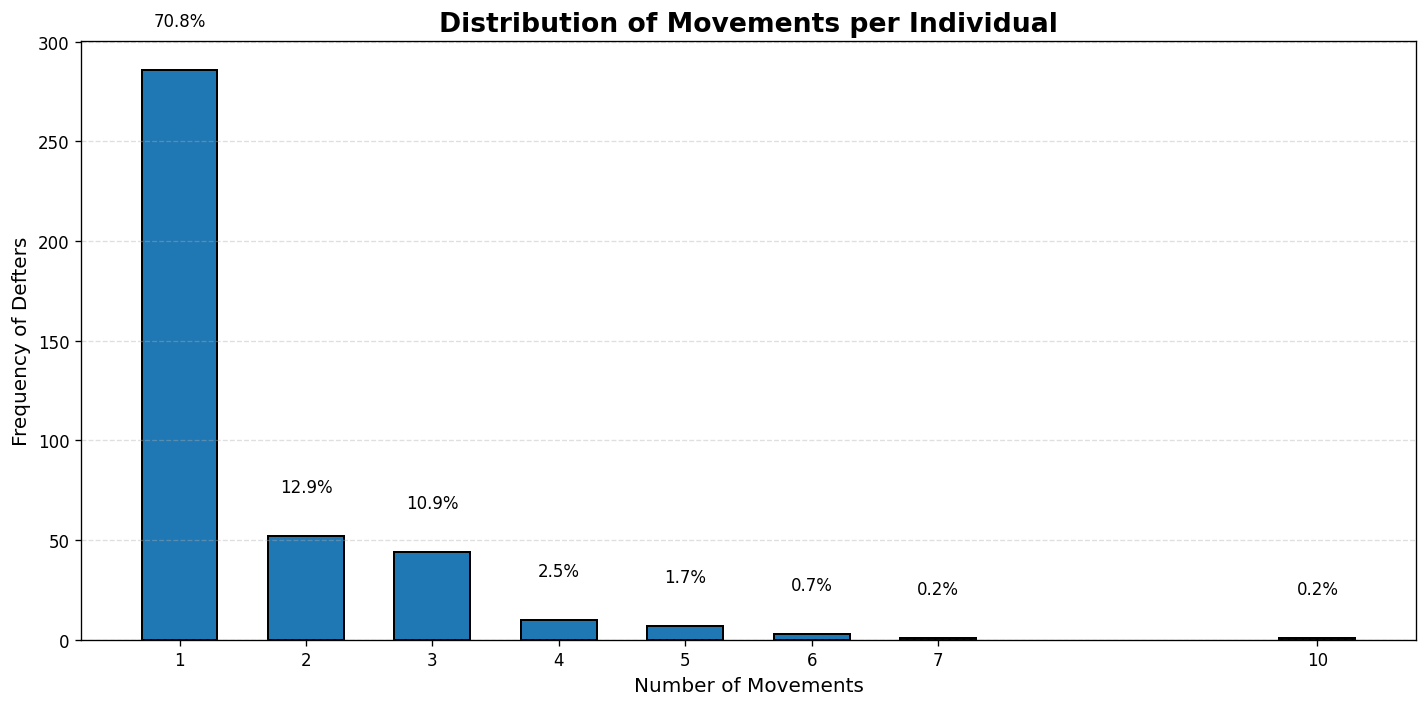


=== Top 5 Places of Origin ===


,Place of origin,Count,Pct
0,Asitane,113,30.874317
1,Şarköy,16,4.371585
2,Yanya,12,3.278689
3,Midil,8,2.185792
4,Trabzon,8,2.185792


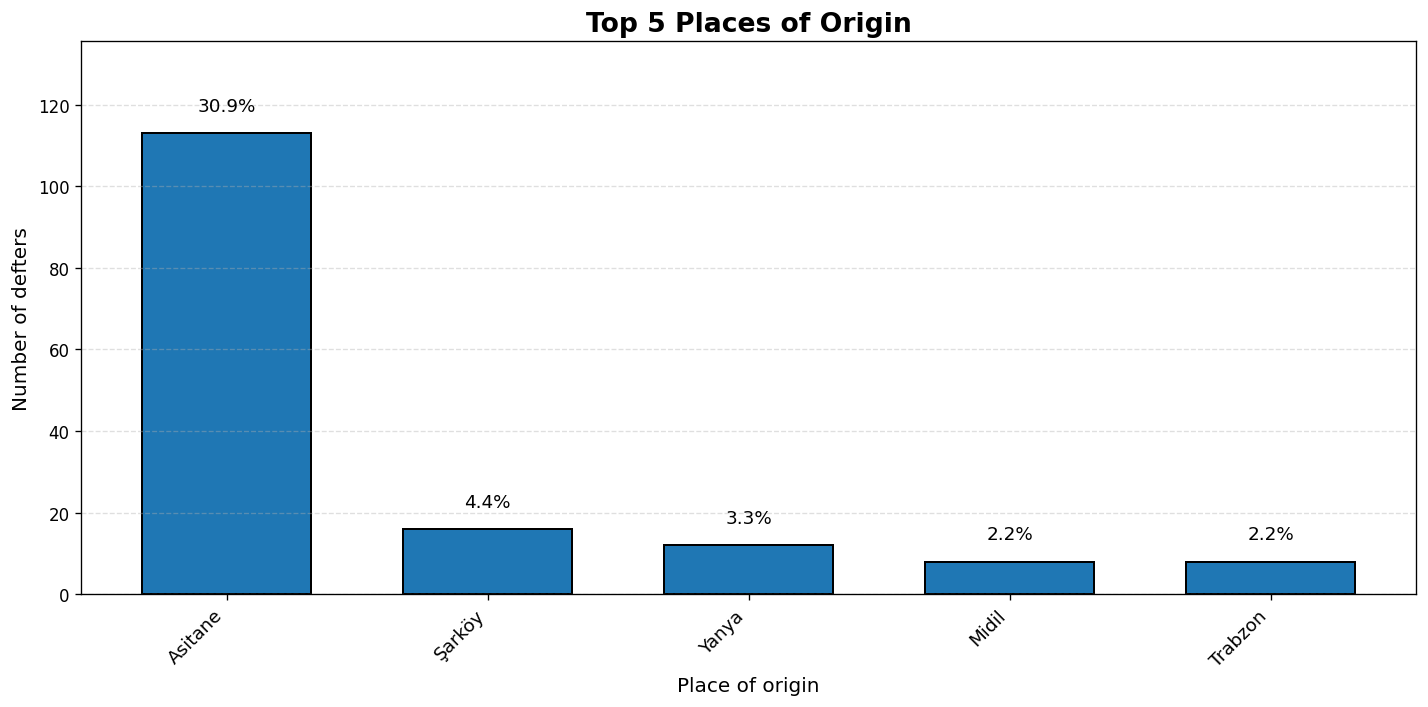


=== Top Destinations per Step ===


,Step,Place,Count,Pct
221,location_10,Adapazarı,1,100.000000
222,location_11,Fener,1,100.000000
0,location_2,Izmir,19,4.702970
1,location_2,Silivri,18,4.455446
2,location_2,Bursa,16,3.960396
3,location_2,Aynaroz,15,3.712871
4,location_2,Kuds,14,3.465347
5,location_2,Tekfurdağı,13,3.217822
6,location_2,Şarköy,12,2.970297
7,location_2,Edirne,11,2.722772


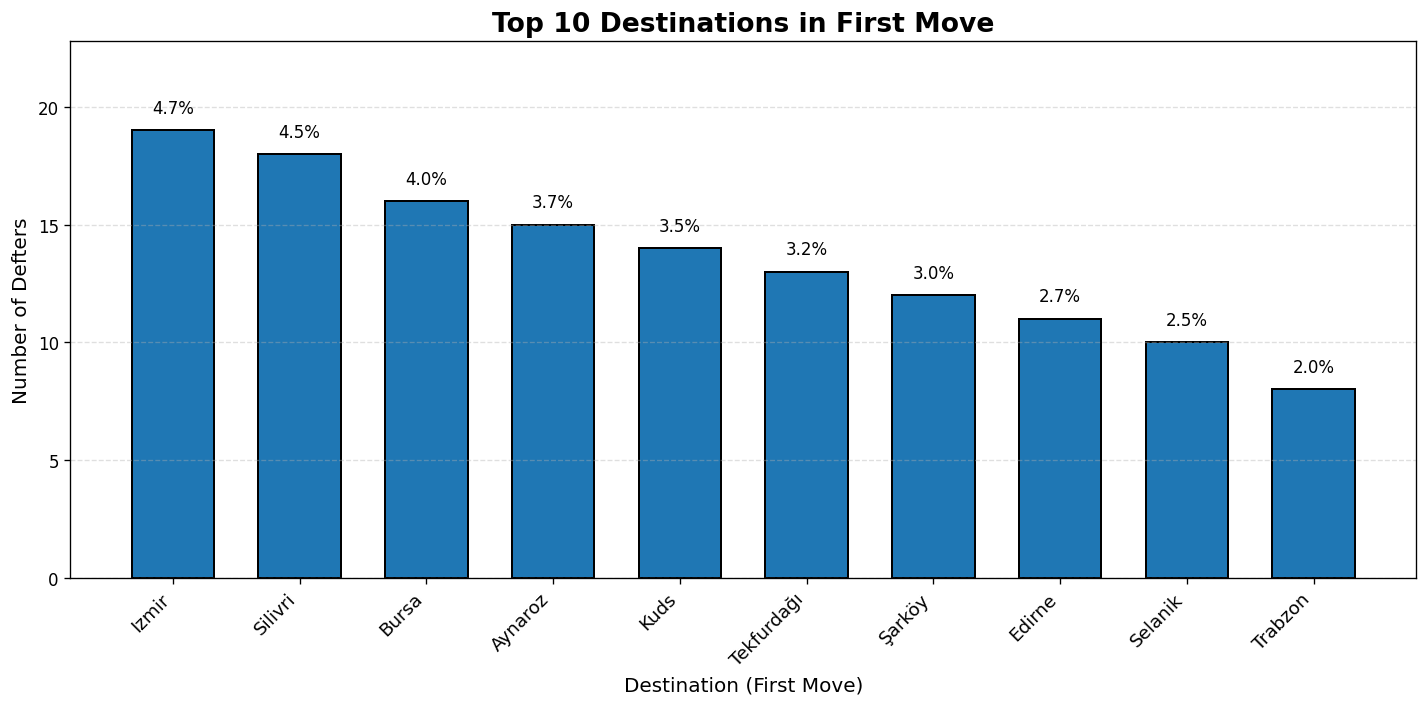

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import re
import numpy as np

sheet_full = "Full Data Tatavla"

df_full = pd.read_excel(file_with_context, sheet_name=sheet_full)

df_moves = df_full[df_full["Formatting Evaluation"] == 1].copy()

print(f"Total records in sheet: {len(df_full)}")
print(f"Records after filtering Formatting Evaluation == 1: {len(df_moves)}")

location_cols = [c for c in df_moves.columns 
                 if re.fullmatch(r"location_\d+", c)]

location_cols = sorted(location_cols, key=lambda x: int(x.split("_")[1]))

print("\nMovement columns considered (clean):")
print(location_cols)

def normalize_location_name(x):
    if pd.isna(x):
        return x
    if not isinstance(x, str):
        return x
    s = x.strip()
    s_lower = s.lower()

    if s_lower.endswith("li") and len(s_lower) > 3:
        s_lower = s_lower[:-2].strip()

   
    return s_lower.title()

cols_to_normalize = ["Place of origin"] + location_cols
for col in cols_to_normalize:
    if col in df_moves.columns:
        df_moves[col] = df_moves[col].apply(normalize_location_name)

movement_cols = location_cols[1:]

df_moves["n_moves"] = df_moves[movement_cols].notna().sum(axis=1)

print("\n=== Movement Count Statistics per Person (excluding starting point) ===")
display(df_moves["n_moves"].describe().to_frame(name="Movement Count Stats"))

value_counts = df_moves["n_moves"].value_counts().sort_index()
steps = value_counts.index.values
counts = value_counts.values
total_individuals = df_moves.shape[0]

plt.figure(figsize=(12, 6), dpi=120)

bars = plt.bar(steps, counts, width=0.6, edgecolor='black', linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xlabel("Number of Movements", fontsize=12)
plt.ylabel("Frequency of Defters", fontsize=12)
plt.title("Distribution of Movements per Individual", fontsize=16, fontweight='bold')

for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = count / total_individuals * 100 if total_individuals > 0 else 0.0
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 20,
             f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.xticks(steps)
plt.tight_layout()
plt.show()

origin_counts = df_moves["Place of origin"].value_counts(dropna=True)
total_origin = origin_counts.sum()

df_origin = pd.DataFrame({
    "Place of origin": origin_counts.index,
    "Count": origin_counts.values
})
df_origin["Pct"] = df_origin["Count"] / total_origin * 100

print("\n=== Top 5 Places of Origin ===")
display(df_origin.head(5))

top_origin = df_origin.head(5)

plt.figure(figsize=(12, 6), dpi=120)
bars = plt.bar(top_origin["Place of origin"].astype(str),
               top_origin["Count"],
               width=0.65,
               edgecolor='black',
               linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xlabel("Place of origin", fontsize=12)
plt.ylabel("Number of defters", fontsize=12)
plt.title("Top 5 Places of Origin", fontsize=16, fontweight='bold')

plt.xticks(rotation=45, ha="right", fontsize=11)

max_count = top_origin["Count"].max()
offset = max_count * 0.04
plt.ylim(0, max_count * 1.20)

for bar, (_, row) in zip(bars, top_origin.iterrows()):
    height = bar.get_height()
    pct = row["Pct"]
    plt.text(bar.get_x() + bar.get_width()/2,
             height + offset,
             f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

step_freq_list = []

for col in movement_cols: 
    vc = df_moves[col].value_counts(dropna=True)
    total = vc.sum()
    for place, count in vc.items():
        step_freq_list.append({
            "Step": col,
            "Place": place,
            "Count": count,
            "Pct": count / total * 100 if total > 0 else 0.0
        })

df_step_freq = pd.DataFrame(step_freq_list)

print("\n=== Top Destinations per Step ===")
display(df_step_freq.sort_values(["Step", "Count"], ascending=[True, False]).head(30))

if "location_2" in movement_cols:
    top_loc2 = (
        df_step_freq[df_step_freq["Step"] == "location_2"]
        .sort_values("Count", ascending=False)
        .head(10)
    )

    total_first_moves = df_step_freq[df_step_freq["Step"] == "location_2"]["Count"].sum()

    plt.figure(figsize=(12, 6), dpi=120)
    bars = plt.bar(top_loc2["Place"].astype(str),
                   top_loc2["Count"],
                   width=0.65,
                   edgecolor='black',
                   linewidth=1.2)

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xlabel("Destination (First Move)", fontsize=12)
    plt.ylabel("Number of Defters", fontsize=12)
    plt.title("Top 10 Destinations in First Move",
              fontsize=16, fontweight='bold')

    plt.xticks(rotation=45, ha="right", fontsize=11)

    max_count = top_loc2["Count"].max()
    offset = max_count * 0.03
    plt.ylim(0, max_count * 1.20)

    for bar, (_, row) in zip(bars, top_loc2.iterrows()):
        height = bar.get_height()
        pct = row["Count"] / total_first_moves * 100 if total_first_moves > 0 else 0.0
        plt.text(bar.get_x() + bar.get_width()/2,
                 height + offset,
                 f"{pct:.1f}%",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()





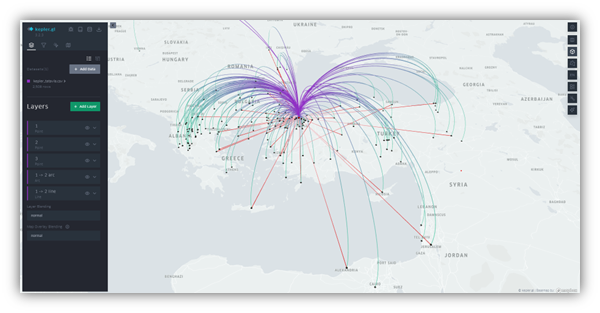

In [31]:
from IPython.display import Image, display

display(Image("./media/tatavla_analysis4.png"))

#### Fener

Total records in sheet: 417
Records after filtering Formatting Evaluation == 1: 404

Movement columns considered (clean):
['location_1', 'location_2', 'location_3', 'location_4', 'location_5', 'location_6', 'location_7', 'location_8', 'location_9', 'location_10', 'location_11']

=== Movement Count Statistics per Person (excluding starting point) ===


,Movement Count Stats
count,404.000000
mean,1.564356
std,1.106407
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,10.000000


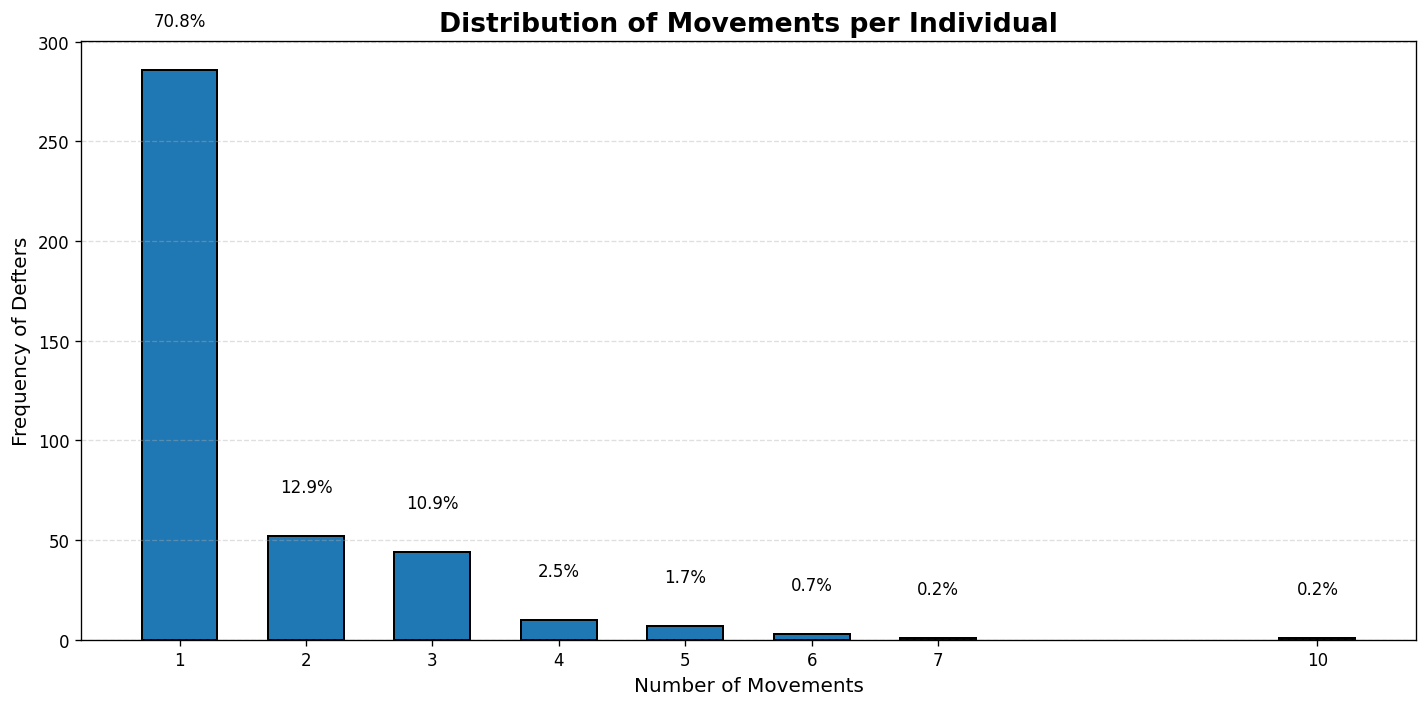


=== Top 5 Places of Origin ===


,Place of origin,Count,Pct
0,Asitane,113,30.874317
1,Şarköy,16,4.371585
2,Yanya,12,3.278689
3,Midil,8,2.185792
4,Trabzon,8,2.185792


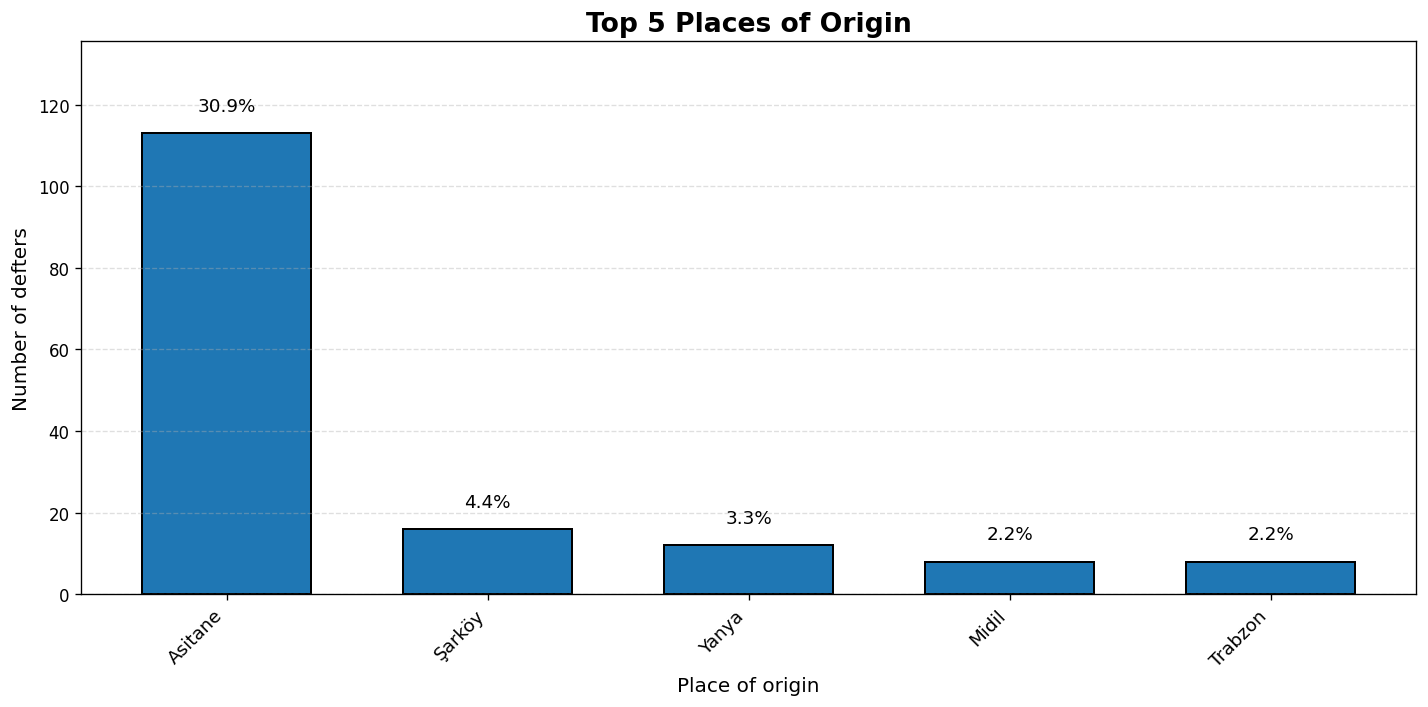


=== Top Destinations per Step ===


,Step,Place,Count,Pct
221,location_10,Adapazarı,1,100.000000
222,location_11,Fener,1,100.000000
0,location_2,Izmir,19,4.702970
1,location_2,Silivri,18,4.455446
2,location_2,Bursa,16,3.960396
3,location_2,Aynaroz,15,3.712871
4,location_2,Kuds,14,3.465347
5,location_2,Tekfurdağı,13,3.217822
6,location_2,Şarköy,12,2.970297
7,location_2,Edirne,11,2.722772


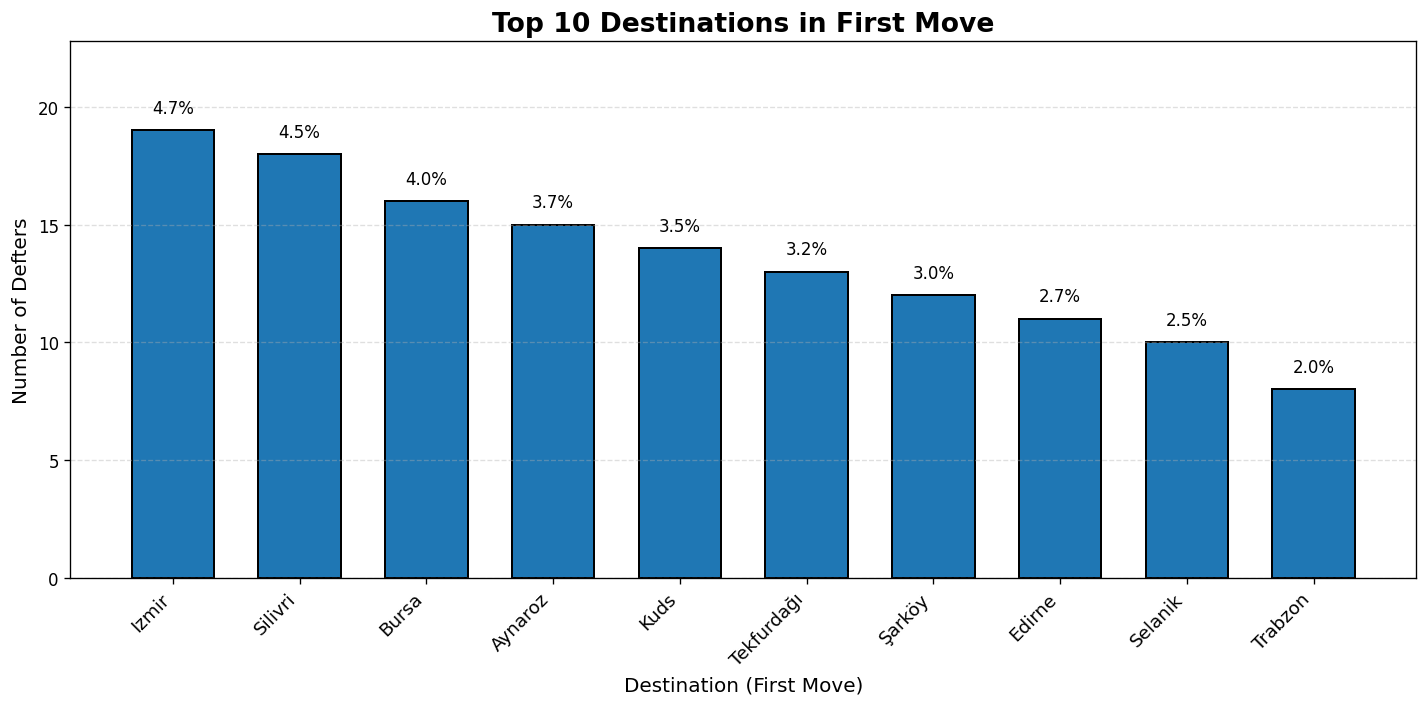

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import re
import numpy as np

sheet_full = "Full Data Fener"

df_full = pd.read_excel(file_with_context, sheet_name=sheet_full)

df_moves = df_full[df_full["Formatting Evaluation"] == 1].copy()

print(f"Total records in sheet: {len(df_full)}")
print(f"Records after filtering Formatting Evaluation == 1: {len(df_moves)}")

location_cols = [c for c in df_moves.columns 
                 if re.fullmatch(r"location_\d+", c)]

location_cols = sorted(location_cols, key=lambda x: int(x.split("_")[1]))

print("\nMovement columns considered (clean):")
print(location_cols)

def normalize_location_name(x):
    if pd.isna(x):
        return x
    if not isinstance(x, str):
        return x
    s = x.strip()
    s_lower = s.lower()

    if s_lower.endswith("li") and len(s_lower) > 3:
        s_lower = s_lower[:-2].strip()

    return s_lower.title()

cols_to_normalize = ["Place of origin"] + location_cols
for col in cols_to_normalize:
    if col in df_moves.columns:
        df_moves[col] = df_moves[col].apply(normalize_location_name)

movement_cols = location_cols[1:]

df_moves["n_moves"] = df_moves[movement_cols].notna().sum(axis=1)

print("\n=== Movement Count Statistics per Person (excluding starting point) ===")
display(df_moves["n_moves"].describe().to_frame(name="Movement Count Stats"))

value_counts = df_moves["n_moves"].value_counts().sort_index()
steps = value_counts.index.values
counts = value_counts.values
total_individuals = df_moves.shape[0]

plt.figure(figsize=(12, 6), dpi=120)

bars = plt.bar(steps, counts, width=0.6, edgecolor='black', linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xlabel("Number of Movements", fontsize=12)
plt.ylabel("Frequency of Defters", fontsize=12)
plt.title("Figure X. Distribution of Movements per Individual", fontsize=16, fontweight='bold')

for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = count / total_individuals * 100 if total_individuals > 0 else 0.0
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 20,
             f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.xticks(steps)
plt.tight_layout()
plt.show()

origin_counts = df_moves["Place of origin"].value_counts(dropna=True)
total_origin = origin_counts.sum()

df_origin = pd.DataFrame({
    "Place of origin": origin_counts.index,
    "Count": origin_counts.values
})
df_origin["Pct"] = df_origin["Count"] / total_origin * 100

print("\n=== Top 5 Places of Origin ===")
display(df_origin.head(5))

top_origin = df_origin.head(5)

plt.figure(figsize=(12, 6), dpi=120)
bars = plt.bar(top_origin["Place of origin"].astype(str),
               top_origin["Count"],
               width=0.65,
               edgecolor='black',
               linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xlabel("Place of origin", fontsize=12)
plt.ylabel("Number of defters", fontsize=12)
plt.title("Figure X. Top 5 Places of Origin", fontsize=16, fontweight='bold')

plt.xticks(rotation=45, ha="right", fontsize=11)

max_count = top_origin["Count"].max()
offset = max_count * 0.04
plt.ylim(0, max_count * 1.20)

for bar, (_, row) in zip(bars, top_origin.iterrows()):
    height = bar.get_height()
    pct = row["Pct"]
    plt.text(bar.get_x() + bar.get_width()/2,
             height + offset,
             f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

step_freq_list = []

for col in movement_cols:  
    vc = df_moves[col].value_counts(dropna=True)
    total = vc.sum()
    for place, count in vc.items():
        step_freq_list.append({
            "Step": col,
            "Place": place,
            "Count": count,
            "Pct": count / total * 100 if total > 0 else 0.0
        })

df_step_freq = pd.DataFrame(step_freq_list)

print("\n=== Top Destinations per Step ===")
display(df_step_freq.sort_values(["Step", "Count"], ascending=[True, False]).head(30))

if "location_2" in movement_cols:
    top_loc2 = (
        df_step_freq[df_step_freq["Step"] == "location_2"]
        .sort_values("Count", ascending=False)
        .head(10)
    )

    total_first_moves = df_step_freq[df_step_freq["Step"] == "location_2"]["Count"].sum()

    plt.figure(figsize=(12, 6), dpi=120)
    bars = plt.bar(top_loc2["Place"].astype(str),
                   top_loc2["Count"],
                   width=0.65,
                   edgecolor='black',
                   linewidth=1.2)

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xlabel("Destination (First Move)", fontsize=12)
    plt.ylabel("Number of Defters", fontsize=12)
    plt.title("Figure X. Top 10 Destinations in First Move",
              fontsize=16, fontweight='bold')

    plt.xticks(rotation=45, ha="right", fontsize=11)

    max_count = top_loc2["Count"].max()
    offset = max_count * 0.03
    plt.ylim(0, max_count * 1.20)

    for bar, (_, row) in zip(bars, top_loc2.iterrows()):
        height = bar.get_height()
        pct = row["Count"] / total_first_moves * 100 if total_first_moves > 0 else 0.0
        plt.text(bar.get_x() + bar.get_width()/2,
                 height + offset,
                 f"{pct:.1f}%",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()





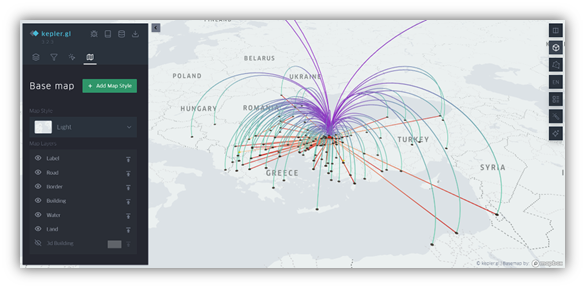

In [8]:
from IPython.display import Image, display

display(Image("./media/fener_analysis4.png"))